### Qulacs を用いてQuantum Volume Benchmark用のコードをシミュレートする

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算
from qulacs.gate import U1,U2,U3 #IBM Gate

### Hadamardのベンチマーク
準備として、計測用のコードを書いておきます。

In [2]:
import time
bench_result_H=[[],[]]

for i in range(15):
    nqubits = i+5
    state = QuantumState(nqubits)
    state.set_zero_state()
    circuit = QuantumCircuit(nqubits)
    for j in range(nqubits):
        circuit.add_gate(H(j)) #全部の量子ビットにHを作用させる回路を構成
    
    count = 0
    
    #計測スタート
    start = time.time()
    while time.time() - start < 1:
        count = count+1
        circuit.update_quantum_state(state)
    elapsed_time = (time.time() - start)/(count*nqubits)
    #計測終了
    
    total_counts = count*nqubits
    bench_result_H[0].append(nqubits)    
    bench_result_H[1].append(elapsed_time)
    
    print ("number of qubit:{0}".format(nqubits)+" time:{0}".format(elapsed_time) + "[sec]")

number of qubit:5 time:4.6129244280037406e-05[sec]
number of qubit:6 time:4.7032740261430936e-05[sec]
number of qubit:7 time:4.543065754034669e-05[sec]
number of qubit:8 time:4.5086281677036996e-05[sec]
number of qubit:9 time:4.6061652687179204e-05[sec]
number of qubit:10 time:4.794371322383131e-05[sec]
number of qubit:11 time:5.016391222200679e-05[sec]
number of qubit:12 time:5.423334978377061e-05[sec]
number of qubit:13 time:6.242161033916432e-05[sec]
number of qubit:14 time:7.842724387204925e-05[sec]
number of qubit:15 time:0.00011518293917693828[sec]
number of qubit:16 time:0.00021189169303790942[sec]
number of qubit:17 time:0.00038546793555260074[sec]
number of qubit:18 time:0.0007461184042471426[sec]
number of qubit:19 time:0.001367342777741261[sec]


<function matplotlib.pyplot.show(*args, **kw)>

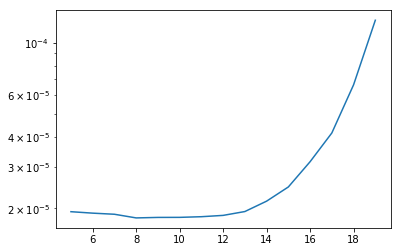

In [6]:
import matplotlib.pyplot as plt
plt.yscale("log")
plt.plot(bench_result_H[0],bench_result_H[1])
plt.show

自動`merge`昨日である、`QuantumCircuitOptimizer`を用いてゲートをまとめてシミュレーション時間を比較する。

In [11]:
nqubits = 20

for j in range(2,10):
    state = QuantumState(nqubits)
    state.set_zero_state()

    circuit = QuantumCircuit(nqubits)

    for i in range(nqubits*nqubits*10):
        random_matrix = np.array([[random.random() for i in range(4)] for k in range(4)])
        circuit.add_gate(DenseMatrix(random.sample(range(nqubits),2),random_matrix))
    
    opt = QuantumCircuitOptimizer()
    max_block_size = j
    opt.optimize(circuit, max_block_size)

    start = time.time()
    circuit.update_quantum_state(state)
    elapsed_time = (time.time() - start)
    print("{0}".format(max_block_size) + "qubit block time:{0}".format(elapsed_time) + "[sec]")





2qubit block time:22.380998849868774[sec]
3qubit block time:10.128243207931519[sec]
4qubit block time:6.898831844329834[sec]
5qubit block time:7.151185750961304[sec]
6qubit block time:11.019920349121094[sec]
7qubit block time:19.630569219589233[sec]
8qubit block time:37.586716175079346[sec]
9qubit block time:82.80436253547668[sec]


QASMをパースして`QuantumCircuit`を生成する。

In [2]:
import re
import parse


def parse_qasm_to_QulacsCircuit(input_filename,qulacs_circuit):

    with open(input_filename, "r") as ifile:
        lines = ifile.readlines()

        for line in lines:
            s = re.search(r"qreg|cx|u3|u1", line)

            if s is None:
                continue

            elif s.group() == 'qreg':
                match = re.search(r"\d\d*", line)
                print(match)
                continue

            elif s.group() == 'cx':
                match = re.findall(r"\[\d\d*\]", line)  # int抽出
                c_qbit = int(match[0].strip('[]'))
                t_qbit = int(match[1].strip('[]'))
                qulacs_circuit.add_gate(CNOT(c_qbit,t_qbit))   

                continue

            elif s.group() == 'u3':
                m_r = re.findall(r"[-]?\d\.\d\d*", line)  # real抽出, 負符号考慮
                m_i = re.findall(r"\[\d\d*\]", line)  # int抽出

                # target_bit = m_i[0]
                # u3parameters = m_r
                qulacs_circuit.add_gate(U3(int(m_i[0].strip('[]')),float(m_r[0]),float(m_r[1]),float(m_r[2])))

                continue

            elif s.group() == 'u1':
                m_r = re.findall(r"[-]?\d\.\d\d*", line)  # real抽出
                m_i = re.findall(r"\[\d\d*\]", line)  # int抽出

                qulacs_circuit.add_gate(U1(int(m_i[0].strip('[]')),float(m_r[0])))

                continue



In [ ]:
きちんと取り込めているか確認してみる。Quantum volume benchmarkの生成コードは、[ここから]()。

In [32]:
nqubits = 10
state = QuantumState(10)
state.set_zero_state()
circuit = QuantumCircuit(10)
parse_qasm_to_QulacsCircuit("./QvolBench/quantum_volume_n{0}".format(nqubits)+"_d10_i.qasm",circuit)
print(circuit)

<_sre.SRE_Match object; span=(6, 7), match='0'>
*** Quantum Circuit Info ***
# of qubit: 10
# of step : 70
# of gate : 500
# of 1 qubit gate: 350
# of 2 qubit gate: 150
Clifford  : no
Gaussian  : no




In [33]:
#計測スタート
state.set_zero_state()
start = time.time()
circuit.update_quantum_state(state)
elapsed_time = time.time() - start
print ("number of qubit:{0}".format(nqubits)+" time:{0}".format(elapsed_time) + "[sec]")

number of qubit:10 time:0.012296915054321289[sec]


In [34]:
opt = QuantumCircuitOptimizer()
max_block_size = 2
opt.optimize(circuit, max_block_size)
print(circuit)

state.set_zero_state()
start = time.time()
circuit.update_quantum_state(state)
elapsed_time = time.time() - start
print ("number of qubit:{0}".format(nqubits)+" time:{0}".format(elapsed_time) + "[sec]")

*** Quantum Circuit Info ***
# of qubit: 10
# of step : 10
# of gate : 46
# of 1 qubit gate: 0
# of 2 qubit gate: 46
Clifford  : no
Gaussian  : no


number of qubit:10 time:0.0022644996643066406[sec]


### 計測する

In [3]:
bench_result_quantum_volume = [[],[]]

for i in range(10):
    nqubits = 2*i+10
    state = QuantumState(nqubits)
    state.set_zero_state()
    circuit = QuantumCircuit(nqubits)
    parse_qasm_to_QulacsCircuit("./QvolBench/quantum_volume_n{0}".format(nqubits)+"_d10_i.qasm",circuit)
    #print(circuit)

    opt = QuantumCircuitOptimizer()
    max_block_size = 2
    opt.optimize(circuit, max_block_size)
    #print(circuit)

    state.set_zero_state()
    start = time.time()
    circuit.update_quantum_state(state)
    elapsed_time = time.time() - start
    print ("number of qubit:{0}".format(nqubits)+" time:{0}".format(elapsed_time) + "[sec]")
    
    bench_result_quantum_volume[0].append(nqubits)    
    bench_result_quantum_volume[1].append(elapsed_time)
    

<_sre.SRE_Match object; span=(6, 7), match='0'>
number of qubit:10 time:0.002992868423461914[sec]
<_sre.SRE_Match object; span=(6, 7), match='0'>
number of qubit:12 time:0.003975391387939453[sec]
<_sre.SRE_Match object; span=(6, 7), match='0'>
number of qubit:14 time:0.013583183288574219[sec]
<_sre.SRE_Match object; span=(6, 7), match='0'>
number of qubit:16 time:0.05003213882446289[sec]
<_sre.SRE_Match object; span=(6, 7), match='0'>
number of qubit:18 time:0.21669888496398926[sec]
<_sre.SRE_Match object; span=(6, 7), match='0'>
number of qubit:20 time:0.7942399978637695[sec]
<_sre.SRE_Match object; span=(6, 7), match='0'>
number of qubit:22 time:3.5742249488830566[sec]
<_sre.SRE_Match object; span=(6, 7), match='0'>
number of qubit:24 time:17.73240089416504[sec]
<_sre.SRE_Match object; span=(6, 7), match='0'>
number of qubit:26 time:69.48712587356567[sec]
<_sre.SRE_Match object; span=(6, 7), match='0'>
number of qubit:28 time:306.79954981803894[sec]


<function matplotlib.pyplot.show>

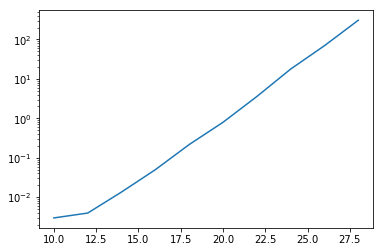

In [5]:
import matplotlib.pyplot as plt
plt.yscale("log")
plt.plot(bench_result_quantum_volume[0],bench_result_quantum_volume[1])
plt.show

In [8]:
for i in range(10):
    print(bench_result_quantum_volume[0][i],bench_result_quantum_volume[1][i])

10 0.002992868423461914
12 0.003975391387939453
14 0.013583183288574219
16 0.05003213882446289
18 0.21669888496398926
20 0.7942399978637695
22 3.5742249488830566
24 17.73240089416504
26 69.48712587356567
28 306.79954981803894


<function matplotlib.pyplot.show>

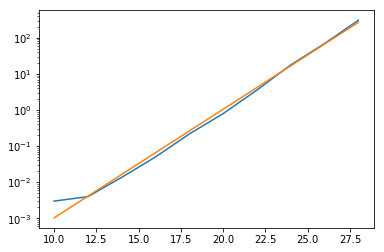

In [24]:
import matplotlib.pyplot as plt
plt.yscale("log")
plt.plot(bench_result_quantum_volume[0],bench_result_quantum_volume[1])
plt.plot([x for x in range(10,29)],[2**x/1000000 for x in range(10,29)])
plt.show